In [1]:
import functools
import numpy as np
import jax
from brax import envs
from brax.io import model, html
from brax.training.agents.apg import networks as apg_networks
from brax.training.acme import running_statistics
from diffmimic.mimic_envs import register_mimic_env
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt

In [2]:
# env
register_mimic_env()

f = '/data/benny_cai/diffmimic/A1_logs/exp_64_32_0.0003_500_0.4_0_threshold_0.2_True_66_66_66_True_0.02_1_0.5_0.01_0.01_10_jump_forward_50Hz/eval_traj_best.npy'
rollout_traj = np.load(f)

if len(rollout_traj.shape) == 3:
    seed = 0
    rollout_traj = rollout_traj[:, seed]

env = envs.get_environment(env_name="a1_mimic", reference_traj=rollout_traj)

In [3]:
# network
network_factory = functools.partial(apg_networks.make_apg_networks, hidden_layer_sizes=(512, 256))
normalize = running_statistics.normalize
apg_network = network_factory(
      env.observation_size,
      env.action_size,
      preprocess_observations_fn=normalize)

# policy
make_policy = apg_networks.make_inference_fn(apg_network)
params = model.load_params('/data/benny_cai/diffmimic/A1_logs/exp_64_32_0.0003_500_0.4_0_threshold_0.2_True_66_66_66_True_0.02_1_0.5_0.01_0.01_10_jump_forward_50Hz/params_best.pkl')
policy = make_policy(params)

In [4]:
# Visualizing a trajectory of the learned inference function
jit_env_reset = jax.jit(env.reset) # reset: retrieve the 1st state from the reference motion
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
act_list = []
for i in range(66):
    print("###########", i)
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    act_list.append(act)
    # print("action: ", act)
    state = jit_env_step(state, act)

########### 0
act: 
[ 5.54577529e-01  2.75752091e+00 -1.51205611e+00  3.45587730e-04
  1.97675800e+00 -9.45952535e-01 -1.06894314e-01  4.52210784e-01
 -2.36918521e+00 -4.40890789e-02  8.10696602e-01 -2.09275675e+00]
bias: 
[  0.    -47.124 157.08    0.    -47.124 157.08    0.    -47.124 157.08
   0.    -47.124 157.08 ]
q: 
[ 0.       0.47124 -1.5708   0.       0.47124 -1.5708   0.       0.47124
 -1.5708   0.       0.47124 -1.5708 ]
force: 
[ 5.5457752e+01  6.6500000e+01  5.8743896e+00  3.4558773e-02
  6.6500000e+01  6.2484749e+01 -1.0689431e+01 -1.9029236e+00
 -4.4500000e+01 -4.4089079e+00  3.3945656e+01 -4.4500000e+01]
act: 
[ 5.54577529e-01  2.75752091e+00 -1.51205611e+00  3.45587730e-04
  1.97675800e+00 -9.45952535e-01 -1.06894314e-01  4.52210784e-01
 -2.36918521e+00 -4.40890789e-02  8.10696602e-01 -2.09275675e+00]
bias: 
[-6.9362298e-02 -4.7566116e+01  1.5756442e+02 -2.4348503e-02
 -4.7527851e+01  1.5748640e+02 -1.5727527e-02 -4.7461025e+01
  1.5745644e+02 -2.0791464e-02 -4.7512676

In [5]:
HTML(html.render(env.sys.replace(dt=env.dt), rollout))

In [6]:
env.sys.link_names

['trunk',
 'FR_hip',
 'FR_thigh',
 'FR_calf',
 'FL_hip',
 'FL_thigh',
 'FL_calf',
 'RR_hip',
 'RR_thigh',
 'RR_calf',
 'RL_hip',
 'RL_thigh',
 'RL_calf']

In [7]:
act_list = np.array(act_list)
act_list.shape

(66, 12)

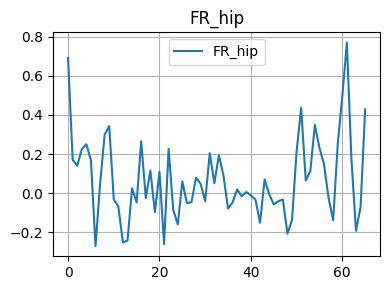

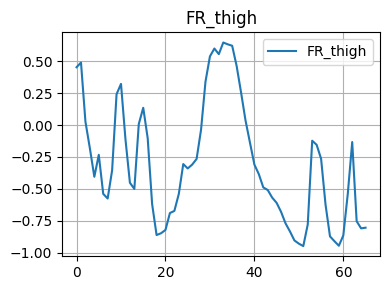

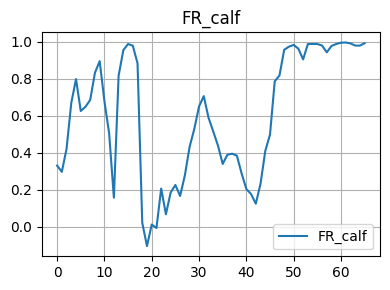

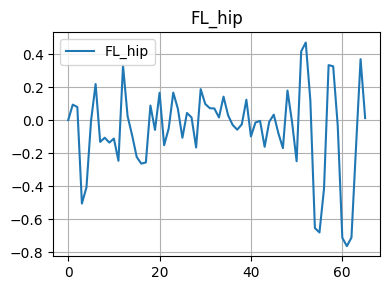

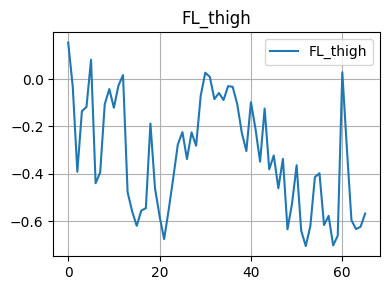

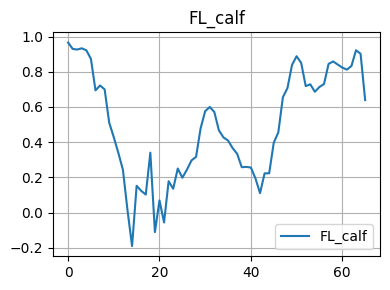

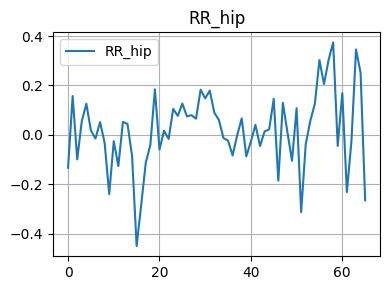

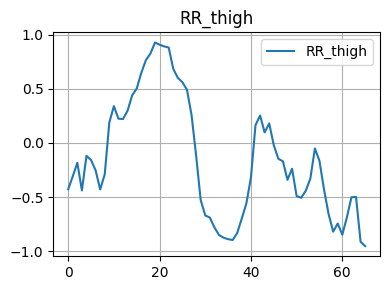

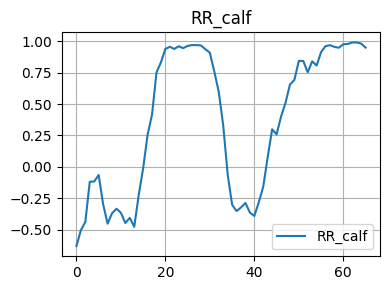

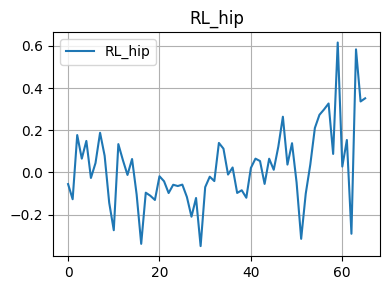

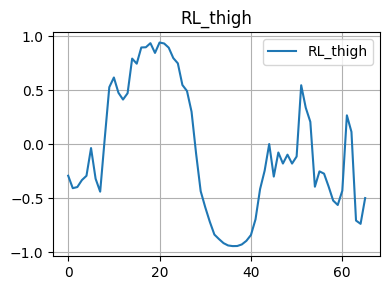

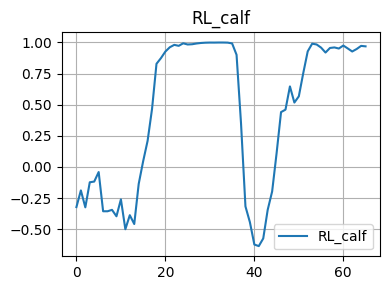

In [8]:
# visualize the actions of all actuators, in range [-1,1]
time = np.arange(66)
for i in range(12):
    link_name = env.sys.link_names[i+1]
    link_act = act_list[:,i]
    plt.figure(figsize=(4, 3))
    plt.plot(time, link_act, label=link_name)
    plt.title(link_name)
    plt.legend() 
    plt.grid(True)
    plt.tight_layout()  

# random try

In [ ]:
# # Visualizing a trajectory of the learned inference function
# jit_env_reset = jax.jit(env.reset) # reset: retrieve the 1st state from the reference motion
# jit_env_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(policy)

# rollout = []
# rng = jax.random.PRNGKey(seed=1)
# state = jit_env_reset(rng=rng)
# act_list = []
# for i in range(66):
#     print(i)
#     rollout.append(state.pipeline_state)
#     act_rng, rng = jax.random.split(rng)
#     act, _ = jit_inference_fn(state.obs, act_rng)
#     act_list.append(act)
#     # print("action: ", act)
#     state = jit_env_step(state, act)

In [ ]:
# HTML(html.render(env.sys.replace(dt=env.dt), rollout))